# Análise Exploratória dos Dados da Base MIMIC-III

O MIMIC (Medical Information Mart for Intensive Care) é um grande banco de dados disponível gratuitamente que inclui dados relacionados à saúde não identificados de pacientes que foram admitidos nas unidades de cuidados intensivos do Beth Israel Deaconess Medical Center.

O MIMIC é composto por dados coletados de dois sistemas de informações clínicas diferentes: CareVue e MetaVision.

Nesta versão da base MIMIC temos atendimentos efetuados de **01/06/2001** a **10/10/2012**.

Número de atendimentos: **58.976**

Número de pacientes atendidos: **46.520**

## Objetivo
Entender como são os elementos desta base para aproveitar esta oportunidade concedida pela disciplina de iniciar o estudo de caso da minha dissertação com uma base de dados médicos reais e utilizada em diversos trabalhos de pesquisa.

## Análise

Imports das bibliotecas

In [722]:
import pandas as pd
# from matplotlib import pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.ticker as ticker

### Pacientes

Número de pacientes

In [723]:
patients_df = pd.read_csv('C:\csvMimic\\v1_4\PATIENTS.csv', usecols=['SUBJECT_ID', 'GENDER', 'DOB', 'EXPIRE_FLAG'])
tam_patients  = patients_df.shape[0]
tam_patients

46520

Número de pacientes por gênero

F    20399
M    26121
Name: GENDER, dtype: int64


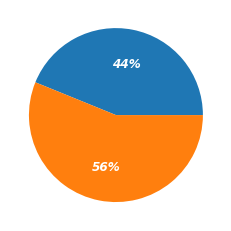

In [724]:
print(patients_df['GENDER'].value_counts(ascending=True, normalize=False))
plt.pie(patients_df['GENDER'].value_counts(ascending=True), labels = ['Mulheres', 'Homens'], autopct='%.0f%%', textprops={'fontsize': 12, 'color': 'white', 'style': 'oblique', 'weight': 'bold'})
plt.show()

Temos que a quantidade de homens e mulheres é próxima, sem grande disparidade.

Qual a taxa de sobrevivência destes pacientes?

In [725]:
survival_total = pd.DataFrame(data=patients_df['EXPIRE_FLAG'].value_counts(ascending=True).reset_index(name='total'))
survival_total['percentual'] = (survival_total['total'] / tam_patients * 100).round(2)
survival_total.rename(columns={'index': 'morreu'}, inplace=True)
survival_total.loc[survival_total['morreu'] == 0, 'morreu'] = 'não'
survival_total.loc[survival_total['morreu'] == 1, 'morreu'] = 'sim'
survival_total

,morreu,total,percentual
0,sim,15759,33.88
1,não,30761,66.12


In [726]:
survival_total_by_gender = patients_df.groupby('EXPIRE_FLAG')['GENDER'].value_counts().reset_index(name='total')
survival_total_by_gender['percentual'] = (survival_total_by_gender['total'] / tam_patients * 100).round(2)
gs_df = pd.DataFrame(data=survival_total_by_gender)
gs_df.rename(columns={'EXPIRE_FLAG': 'morreu', 'GENDER': 'gênero'}, inplace=True)
gs_df.loc[gs_df['morreu'] == 0, 'morreu'] = 'não'
gs_df.loc[gs_df['morreu'] == 1, 'morreu'] = 'sim'
gs_df

,morreu,gênero,total,percentual
0,não,M,17597,37.83
1,não,F,13164,28.30
2,sim,M,8524,18.32
3,sim,F,7235,15.55


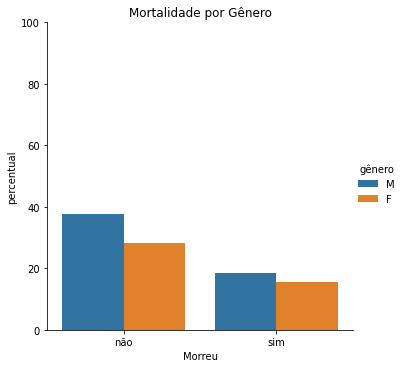

In [727]:
ax = sns.catplot(data=gs_df, x='morreu', y='percentual', kind='bar', hue='gênero')
ax.set(title ="Mortalidade por Gênero", xlabel='Morreu', ylim=(0,100))
ax

<AxesSubplot:title={'center':'Mortalidade por Gênero'}, xlabel='Mortalidade'>

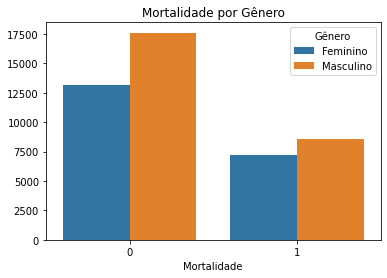

In [728]:
ax = sns.countplot(x="EXPIRE_FLAG", data=patients_df, hue='GENDER')
legend_labels, _= ax.get_legend_handles_labels()
ax.legend(legend_labels, ['Feminino', 'Masculino'], bbox_to_anchor=(1,1), title='Gênero')
ax.set_xlabel("Mortalidade")
ax.set_title("Mortalidade por Gênero")
ax.set_ylabel(None)
ax

A maioria dos pacientes sobrevive e dentre eles os homens são maioria.

**Pergunta:** Essas taxas de sobrevivência são confiáveis? Qual a idade destes pacientes?

### Atendimentos

Número de atendimentos

In [729]:
main_admission_cols = [
    'SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME',
    'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION', 'INSURANCE',
    'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY', 'EDREGTIME',
    'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG']

admissions_df = pd.read_csv('C:\csvMimic\\v1_4\ADMISSIONS.csv', usecols = main_admission_cols)
tam_admissions  = admissions_df.shape[0]
tam_admissions

58976

In [730]:
admissions_df.head()

,SUBJECT_ID,HADM_ID,ADMITTIME,DISCHTIME,DEATHTIME,ADMISSION_TYPE,ADMISSION_LOCATION,DISCHARGE_LOCATION,INSURANCE,LANGUAGE,RELIGION,MARITAL_STATUS,ETHNICITY,EDREGTIME,EDOUTTIME,DIAGNOSIS,HOSPITAL_EXPIRE_FLAG
0,22,165315,2196-04-09 12:26:00,2196-04-10 15:54:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,DISC-TRAN CANCER/CHLDRN H,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2196-04-09 10:06:00,2196-04-09 13:24:00,BENZODIAZEPINE OVERDOSE,0
1,23,152223,2153-09-03 07:15:00,2153-09-08 19:10:00,NaN,ELECTIVE,PHYS REFERRAL/NORMAL DELI,HOME HEALTH CARE,Medicare,NaN,CATHOLIC,MARRIED,WHITE,NaN,NaN,CORONARY ARTERY DISEASE\CORONARY ARTERY BYPASS...,0
2,23,124321,2157-10-18 19:34:00,2157-10-25 14:00:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME HEALTH CARE,Medicare,ENGL,CATHOLIC,MARRIED,WHITE,NaN,NaN,BRAIN MASS,0
3,24,161859,2139-06-06 16:14:00,2139-06-09 12:48:00,NaN,EMERGENCY,TRANSFER FROM HOSP/EXTRAM,HOME,Private,NaN,PROTESTANT QUAKER,SINGLE,WHITE,NaN,NaN,INTERIOR MYOCARDIAL INFARCTION,0
4,25,129635,2160-11-02 02:06:00,2160-11-05 14:55:00,NaN,EMERGENCY,EMERGENCY ROOM ADMIT,HOME,Private,NaN,UNOBTAINABLE,MARRIED,WHITE,2160-11-02 01:01:00,2160-11-02 04:27:00,ACUTE CORONARY SYNDROME,0


Tipos de Atendimento

Temos na base 4 tipos possíveis de tipos de atendimento. São eles:
- emergency: Atendimentos não planejados
- urgent: Atendimentos não planejados
- elective: Atendimentos planejados
- newborn: Nascimentos

Os mantenedores do MIMIC-III indicam que as categorias *emergency* e *urgent* podem ser agrupadas, por terem a mesma natureza.

(0.0, 58976.0)

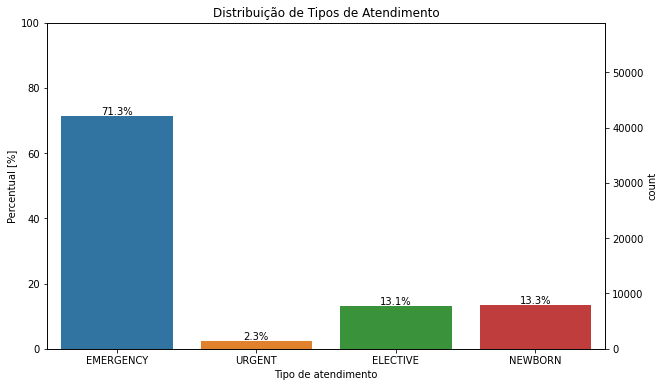

In [731]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="ADMISSION_TYPE", data=admissions_df, order=['EMERGENCY', 'URGENT', 'ELECTIVE', 'NEWBORN'])
plt.title('Distribuição de Tipos de Atendimento')
plt.xlabel('Tipo de atendimento')

# Make twin axis
ax2=ax.twinx()

# Switch so count axis is on right, frequency on left
ax2.yaxis.tick_left()
ax.yaxis.tick_right()

# Also switch the labels over
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

ax2.set_ylabel('Percentual [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_admissions), (x.mean(), y), 
            ha='center', va='bottom') # set the alignment of the text

# Use a LinearLocator to ensure the correct number of ticks
# ax.yaxis.set_major_locator(ticker.LinearLocator(11))

# Fix the frequency range to 0-100
ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_admissions)

# And use a MultipleLocator to ensure a tick spacing of 10
# ax2.yaxis.set_major_locator(ticker.MultipleLocator(10))

# Need to turn the grid on ax2 off, otherwise the gridlines end up on top of the bars
# ax2.grid(None)

Distribuição dos pacientes por idade

Os pacientes foram divididos em 3 grupos etários:
- Com idade de 0 a 1 ano : *neonate*
- Com idade acima entre 14 e 89 anos: *adult*
- Acima de 89 anos: *>89*

Observação: Não foram realizados atendimentos em indivíduos entre 2 e 13 anos, por isso estas idades não são contempladas por nenhuma faixa.

Todas as datas na base incluindo a data de nascimento dos pacientes foi alterada para datas randômicas (no passado e no futuro) para resguardar a privacidade das pessoas envolvidas. Para se obter a idade foi efetuado o cálculo via query SQL da diferença entre a data de nascimento e a data do primeiro atendimento do paciente.

In [732]:
patients_by_age = pd.read_csv('C:\csvMimic\\pacientes-por-idades-2.csv')
patients_by_age.head()

,subject_id,dob,gender,first_admittime,first_admit_age,expire_flag,age_group
0,2,2138-07-17 00:00:00,M,2138-07-17 19:04:00,0.00,0,neonate
1,3,2025-04-11 00:00:00,M,2101-10-20 19:08:00,76.52,1,adult
2,4,2143-05-12 00:00:00,F,2191-03-16 00:28:00,47.84,0,adult
3,5,2103-02-02 00:00:00,M,2103-02-02 04:31:00,0.00,0,neonate
4,6,2109-06-21 00:00:00,F,2175-05-30 07:15:00,65.94,0,adult


Verificando as estatísticas do atributo idade

In [733]:
patients_by_age['first_admit_age'].describe()

count    46520.000000
mean        61.878247
std         57.456175
min          0.000000
25%         38.530000
50%         60.490000
75%         75.510000
max        300.000000
Name: first_admit_age, dtype: float64

Os pacientes com idade superior a 89 anos tiveram a idade alterada para 300 na base do MIMIC-III. No site da base é informado que estes pacientes que tiveram a sua idade alterada para 300 anos tinham média de idade de 91.4. Portanto, calculando a média de idade dos demais pacientes de forma apartada é possível chegarmos à real média de idade dos pacientes atendidos.

In [734]:
neonate_df = patients_by_age.query('first_admit_age < 1')
adults_df = patients_by_age.query('first_admit_age > 1 and first_admit_age < 90')
elderly_df = patients_by_age.query('first_admit_age == 300')

neonate_mean = neonate_df['first_admit_age'].mean()
adults_mean = adults_df['first_admit_age'].mean()
elderly_mean = 91.4

total_mean = ((neonate_mean + adults_mean + elderly_mean)/3).round(2)
no_neonate_mean = ((adults_mean + elderly_mean)/2).round(2)
print('Média total da idade dos pacientes:', total_mean)
print('Média total da idade dos pacientes excluindo recém-nascidos:', no_neonate_mean)

Média total da idade dos pacientes: 51.21
Média total da idade dos pacientes excluindo recém-nascidos: 76.82


Histograma da idade dos pacientes

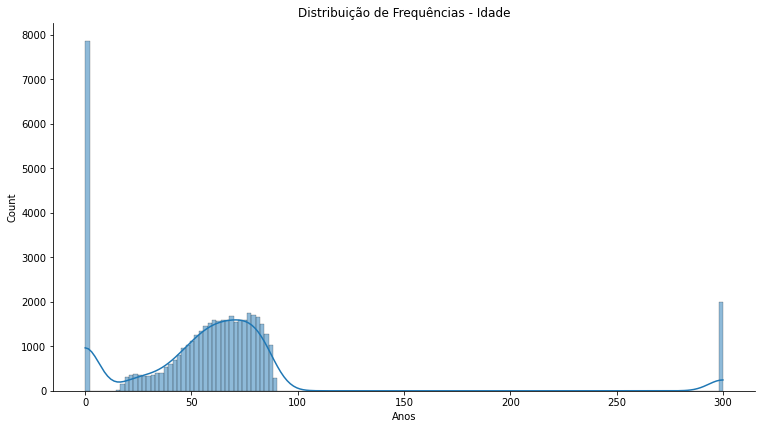

In [735]:
ax = sns.displot(patients_by_age.first_admit_age, kde = True)
ax.figure.set_size_inches(12,6)
ax.set(title ="Distribuição de Frequências - Idade", xlabel='Anos')
ax

Pelo histograma acima a presença de três grupos etários se torna ainda mais evidente. Abaixo, apenas para fins de comprovação, não temos na base pacientes com idade entre 2 e 13 anos.

In [736]:
patients_by_age.query('first_admit_age > 1 and first_admit_age < 14')

,subject_id,dob,gender,first_admittime,first_admit_age,expire_flag,age_group


Distribuição de idade entre os adultos

<AxesSubplot:title={'center':'Distribuição de Frequências - Idade Adulta'}, xlabel='Anos', ylabel='Count'>

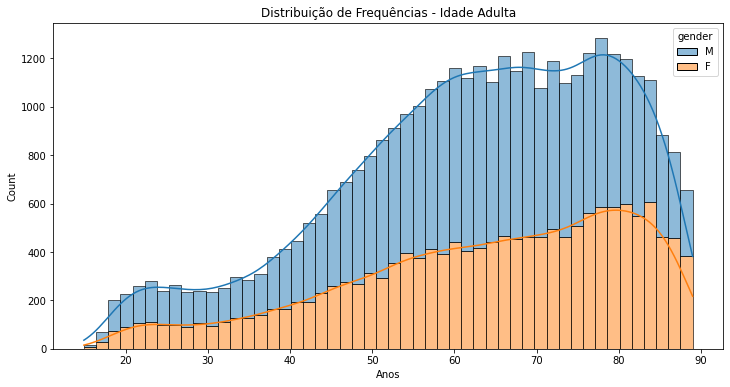

In [737]:
ax = sns.histplot(data=adults_df, x='first_admit_age', kde = True, hue='gender', multiple="stack")
ax.figure.set_size_inches(12,6) 
ax.set(title ="Distribuição de Frequências - Idade Adulta", xlabel='Anos')
ax

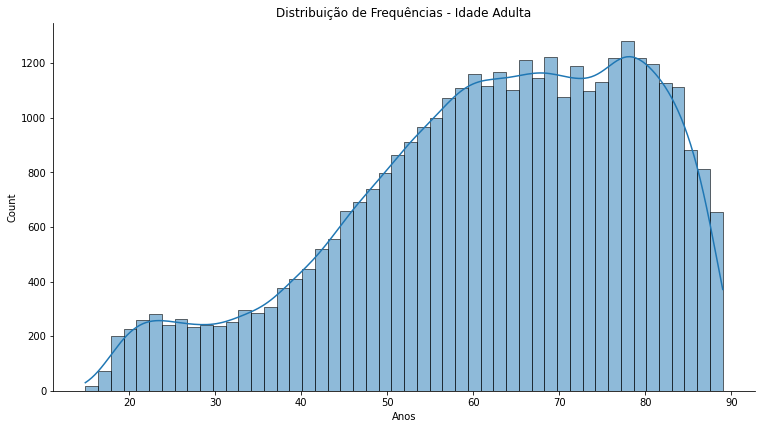

In [738]:
ax = sns.displot(adults_df.first_admit_age, kde = True)
ax.figure.set_size_inches(12,6) 
ax.set(title ="Distribuição de Frequências - Idade Adulta", xlabel='Anos')
ax

<AxesSubplot:title={'center':'Distribuição de Frequências - Idade Adulta'}, xlabel='Anos', ylabel='Density'>

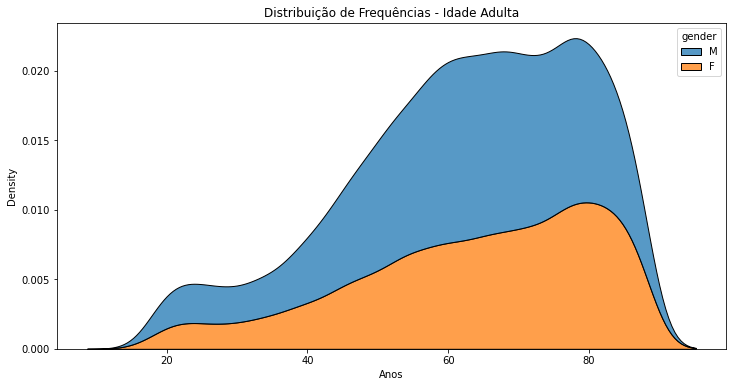

In [739]:
ax = sns.kdeplot(data=adults_df, x='first_admit_age', hue='gender', multiple="stack")
ax.figure.set_size_inches(12,6) 
ax.set(title ="Distribuição de Frequências - Idade Adulta", xlabel='Anos')
ax

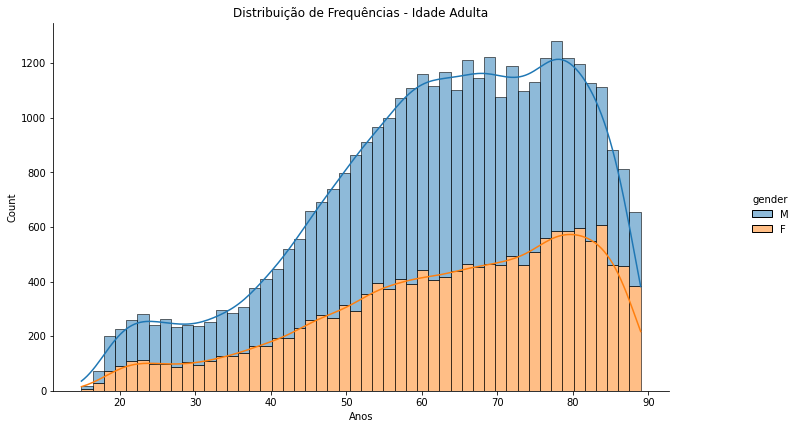

In [740]:
ax = sns.displot(data=adults_df, x= 'first_admit_age', kde = True, hue='gender', multiple="stack")
ax.figure.set_size_inches(12,6) 
ax.set(title ="Distribuição de Frequências - Idade Adulta", xlabel='Anos')
ax

O intervalo de idades na faixa adulta é muito grande. Vamos plotar um boxplot das idades desta faixa para verificar mais claramente em que intervalo de idades estão concentrados a maior parte dos atendimentos.

<AxesSubplot:title={'center':'Idade - Grupo Adulto'}, xlabel='Anos', ylabel='Sexo'>

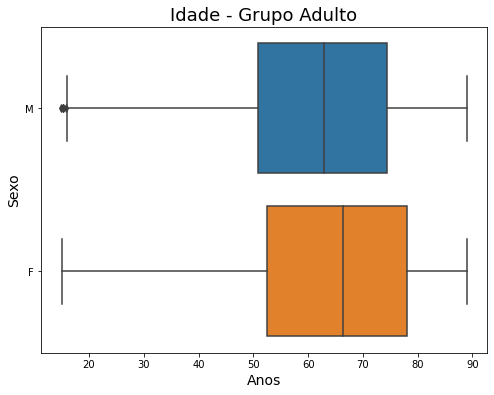

In [741]:
ax = sns.boxplot(x = 'first_admit_age', y='gender', data=adults_df)
ax.figure.set_size_inches(8,6)
ax.set_title('Idade - Grupo Adulto', fontsize=18)
ax.set_xlabel('Anos', fontsize=14)
ax.set_ylabel('Sexo', fontsize=14)
ax

Taxa de mortalidade por grupo etário

In [742]:
tam = patients_by_age.shape[0]
# patients_age_gender_mortality = patients_by_age.groupby(['expire_flag', 'age_group', 'gender'], as_index=False).agg('count')

patients_age_gender_mortality = patients_by_age.groupby(['expire_flag', 'age_group'])['gender'].value_counts().reset_index(name='total')
patients_age_gender_mortality['percentual'] = (patients_age_gender_mortality['total'] / tam * 100).round(2)
patients_age_gender_mortality.rename(columns={'expire_flag': 'morreu', 'gender': 'gênero', 'age_group': 'faixa etária'}, inplace=True)
patients_age_gender_mortality

,morreu,faixa etária,gênero,total,percentual
0,0,>89,F,356,0.77
1,0,>89,M,155,0.33
2,0,adult,M,13235,28.45
3,0,adult,F,9207,19.79
4,0,neonate,M,4207,9.04
5,0,neonate,F,3601,7.74
6,1,>89,F,938,2.02
7,1,>89,M,542,1.17
8,1,adult,M,7944,17.08
9,1,adult,F,6269,13.48


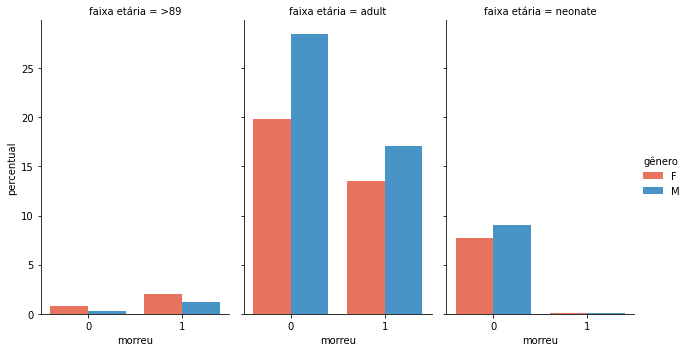

In [743]:
ax = sns.catplot(data=patients_age_gender_mortality, x='morreu', y='percentual', kind='bar', hue='gênero', col='faixa etária', aspect=.6, palette=dict(F="tomato", M="#3498db"))
ax

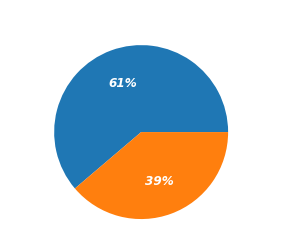

In [744]:
labels_mortality = ['Vivos', 'Mortos']
plt.pie(adults_df['expire_flag'].value_counts(), autopct='%.0f%%', labels = labels_mortality, textprops={'fontsize': 12, 'color': 'white', 'style': 'oblique', 'weight': 'bold'})
plt.title('Taxa de Mortalidade População Adulta', color='white', fontsize=14)
plt.show()

### Duração dos atendimentos

Verificando se temos valores nulos nas datas

In [745]:
print(admissions_df.isnull().values.any())
nan_columns = admissions_df.isna().any()
admissions_df.columns[nan_columns].tolist()

True


['DEATHTIME',
 'LANGUAGE',
 'RELIGION',
 'MARITAL_STATUS',
 'EDREGTIME',
 'EDOUTTIME',
 'DIAGNOSIS']

Dado que não temos dados faltantes, vamos calcular a duração de cada atendimento em dias

In [746]:
admissions_df['ADMITTIME'] = pd.to_datetime(admissions_df['ADMITTIME'])
admissions_df['DISCHTIME'] = pd.to_datetime(admissions_df['DISCHTIME'])

admissions_df['duration'] = (admissions_df['DISCHTIME'] - admissions_df['ADMITTIME']).dt.days

Duração média dos atendimentos

In [747]:
admissions_df.duration.describe()

count    58976.000000
mean         9.610672
std         12.452546
min         -1.000000
25%          3.000000
50%          6.000000
75%         11.000000
max        294.000000
Name: duration, dtype: float64

<AxesSubplot:title={'center':'Boxplot - Duração de Atendimentos'}, xlabel='Dias'>

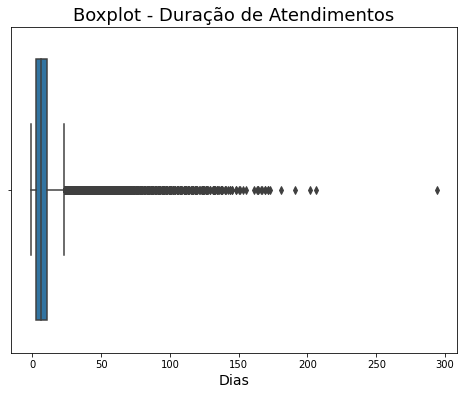

In [748]:
ax = sns.boxplot(x = 'duration', data=admissions_df, orient='h')
ax.figure.set_size_inches(8,6)
ax.set_title('Boxplot - Duração de Atendimentos', fontsize=18)
ax.set_xlabel('Dias', fontsize=14)
ax

<AxesSubplot:title={'center':'Boxplot - Duração de Atendimentos'}, xlabel='Dias', ylabel='Mortalidade'>

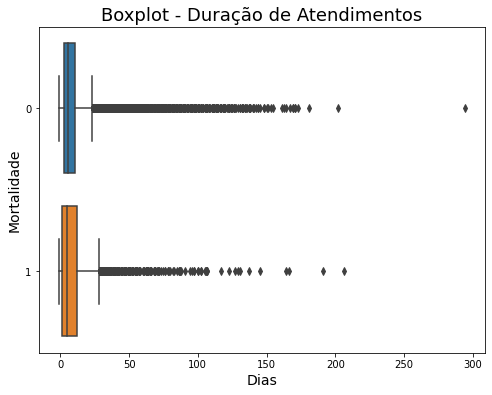

In [749]:
ax = sns.boxplot(x = 'duration', y='HOSPITAL_EXPIRE_FLAG', data=admissions_df, orient='h')
ax.figure.set_size_inches(8,6)
ax.set_title('Boxplot - Duração de Atendimentos', fontsize=18)
ax.set_xlabel('Dias', fontsize=14)
ax.set_ylabel('Mortalidade', fontsize=14)
ax

Duração de atendimento na emergência

In [750]:
aux = admissions_df.copy()
print("Quantidade de registros original: ", aux.shape[0])
aux = aux.dropna()
print("Quantidade de registros após remoção de atendimentos sem estadia na emergência : ", aux.shape[0])

Quantidade de registros original:  58976
Quantidade de registros após remoção de atendimentos sem estadia na emergência :  2053


In [751]:
aux['EDREGTIME'] = pd.to_datetime(aux['EDREGTIME'])
aux['EDOUTTIME'] = pd.to_datetime(aux['EDOUTTIME'])

aux['duration_em'] = (aux['EDOUTTIME'] - aux['EDREGTIME']).dt.seconds

In [752]:
aux['duration_em'] = aux['duration_em'] /3600 # convertendo segundos em horas
print(aux.duration_em.describe())

count    2053.000000
mean        5.061560
std         2.657447
min         0.066667
25%         3.283333
50%         4.600000
75%         6.250000
max        23.383333
Name: duration_em, dtype: float64


## Informações Adicionais

Termos usados na descrição do diagnóstico na entrada do hospital

In [ ]:
admissions_df.columns

Index(['SUBJECT_ID', 'HADM_ID', 'ADMITTIME', 'DISCHTIME', 'DEATHTIME',
       'ADMISSION_TYPE', 'ADMISSION_LOCATION', 'DISCHARGE_LOCATION',
       'INSURANCE', 'LANGUAGE', 'RELIGION', 'MARITAL_STATUS', 'ETHNICITY',
       'EDREGTIME', 'EDOUTTIME', 'DIAGNOSIS', 'HOSPITAL_EXPIRE_FLAG',
       'HAS_CHARTEVENTS_DATA'],
      dtype='object')

In [ ]:

# importar os pacotes necessários
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
 
# importar o arquivo csv em um df
df = pd.read_csv("http://dl.dropboxusercontent.com/s/fdzigk974zbx2de/listings.csv?dl=0")
 
# eliminar as colunas com valores ausentes
summary = df.dropna(subset=['summary'], axis=0)['summary']
# exemplos de descrições para os imóveis no Airbnb
display(summary.iloc[100])
display(summary.iloc[120])
display(summary.iloc[133])
# exemplos de descrições para os imóveis no Airbnb
display(summary.iloc[100])
display(summary.iloc[120])
display(summary.iloc[133])

ModuleNotFoundError: No module named 'wordcloud'

Forma de pagamento dos atendimentos

(0.0, 58976.0)

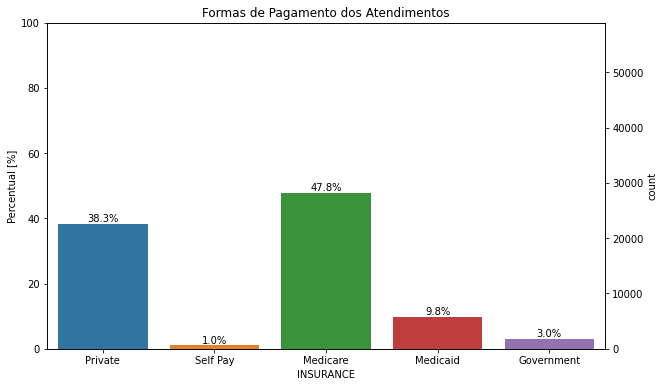

In [ ]:
plt.figure(figsize=(10,6))
ax = sns.countplot(x="INSURANCE", data=admissions_df, order=['Private', 'Self Pay', 'Medicare', 'Medicaid', 'Government'])

ax2=ax.twinx()
ax2.yaxis.tick_left()
ax.yaxis.tick_right()
ax.yaxis.set_label_position('right')
ax2.yaxis.set_label_position('left')

plt.title('Formas de Pagamento dos Atendimentos')
plt.xlabel('Tipo de Pagamento')
ax2.set_ylabel('Percentual [%]')

for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/tam_admissions), (x.mean(), y), 
            ha='center', va='bottom')

ax2.set_ylim(0, 100)
ax.set_ylim(0, tam_admissions)

In [ ]:
admissions['ETHNICITY'].unique()

array(['WHITE', 'UNKNOWN/NOT SPECIFIED', 'MULTI RACE ETHNICITY',
       'BLACK/AFRICAN AMERICAN', 'HISPANIC OR LATINO',
       'PATIENT DECLINED TO ANSWER', 'ASIAN', 'OTHER',
       'HISPANIC/LATINO - GUATEMALAN', 'ASIAN - VIETNAMESE',
       'AMERICAN INDIAN/ALASKA NATIVE', 'WHITE - RUSSIAN',
       'HISPANIC/LATINO - PUERTO RICAN', 'ASIAN - CHINESE',
       'ASIAN - ASIAN INDIAN', 'BLACK/AFRICAN',
       'HISPANIC/LATINO - SALVADORAN', 'HISPANIC/LATINO - DOMINICAN',
       'UNABLE TO OBTAIN', 'BLACK/CAPE VERDEAN', 'BLACK/HAITIAN',
       'WHITE - OTHER EUROPEAN', 'PORTUGUESE', 'SOUTH AMERICAN',
       'WHITE - EASTERN EUROPEAN', 'CARIBBEAN ISLAND', 'ASIAN - FILIPINO',
       'ASIAN - CAMBODIAN', 'HISPANIC/LATINO - CENTRAL AMERICAN (OTHER)',
       'WHITE - BRAZILIAN', 'ASIAN - KOREAN',
       'HISPANIC/LATINO - COLOMBIAN', 'ASIAN - JAPANESE',
       'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER', 'ASIAN - THAI',
       'HISPANIC/LATINO - HONDURAN', 'HISPANIC/LATINO - CUBAN',
       'MID

In [ ]:
admissions['LANGUAGE'].unique()

array([nan, 'ENGL', 'VIET', 'PORT', 'MAND', 'CANT', 'SPAN', 'RUSS',
       'CAPE', '*MAN', 'PTUN', 'HIND', 'ITAL', 'HAIT', 'GREE', 'CAMB',
       '*ARM', '*CHI', 'ALBA', '*DEA', 'POLI', 'FREN', 'ARAB', 'AMER',
       'LAOT', '*PUN', '*URD', '*BUR', '*BEN', '*TOY', '*HUN', 'KORE',
       'THAI', 'PERS', 'ETHI', 'JAPA', '*PHI', '*IBO', '*LEB', '*FUL',
       'URDU', '*SPA', '*RUS', 'SOMA', '* BE', '*CAN', '*CDI', 'TURK',
       '*TOI', 'GERM', '*GUJ', '*BOS', '*BUL', '*TEL', '*YID', '*ROM',
       '**TO', 'BENG', '*AMH', 'TAGA', '* FU', '*MOR', '*ARA', '*YOR',
       '*FAR', '*DUT', 'SERB', '*KHM', '** T', '*NEP', '*CRE', '*FIL',
       '*LIT', '*PER', '**SH', '*TAM'], dtype=object)

In [ ]:
admissions['RELIGION'].unique()

array(['UNOBTAINABLE', 'CATHOLIC', 'PROTESTANT QUAKER', 'NOT SPECIFIED',
       'JEWISH', 'BUDDHIST', 'OTHER', "JEHOVAH'S WITNESS", nan,
       'GREEK ORTHODOX', 'EPISCOPALIAN', 'HINDU', 'CHRISTIAN SCIENTIST',
       'HEBREW', 'METHODIST', 'UNITARIAN-UNIVERSALIST', 'BAPTIST',
       '7TH DAY ADVENTIST', 'MUSLIM', 'ROMANIAN EAST. ORTH', 'LUTHERAN'],
      dtype=object)

In [ ]:
admissions['MARITAL_STATUS'].unique()

array(['MARRIED', 'SINGLE', nan, 'DIVORCED', 'WIDOWED', 'SEPARATED',
       'UNKNOWN (DEFAULT)', 'LIFE PARTNER'], dtype=object)

Primeiros questionamentos:

Quantos pacientes diferentes temos na base do MIMIC-3?
Qual a taxa de recuperação destes pacientes?
Como é essa população de pacientes? Gênero, idade, renda, ocupação.
Qual doença gera mais internações?
Qual doença gera mais internações reincidentes?
Quais os maiores motivos de entrada na emergência?
Quais doenças geram mais mortes?